In [1]:
import numpy as np
import openqcs as o
import openqcs.iterativ as it
import openqcs.spinchain as sp
import openqcs.tools as t

import matplotlib.pyplot as plt

import sys
import os

#########################################################
valid time steps:  56
[0, 38]


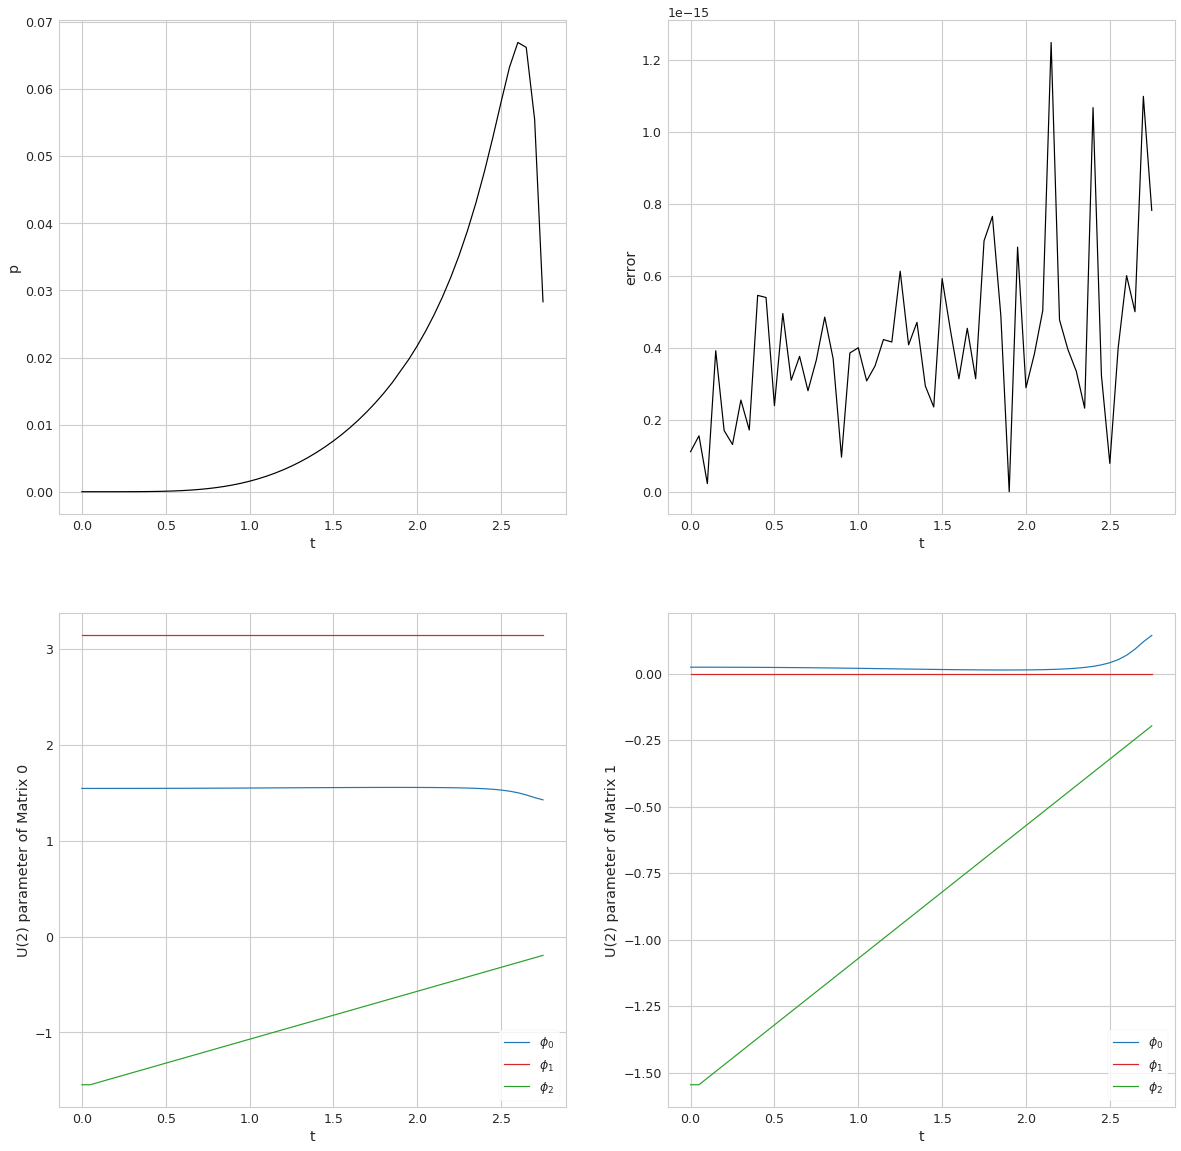

In [2]:
def get_data(a, b, dt, plotting=False):
    H = sp.H_(a,b)
    T = sp.T_(H,dt)
    
    data, err, n_t = it.iterative_evolution(T)
    
    if plotting:
        it.plot_param(data, err, n_t, dt)
    
    return data, n_t

data, n_t = get_data(0.5, 0.5, 0.05, plotting=True)

## Note for Bug Fixing:

For $dt = 0.1$ the pseudo Kraus operator are not special, i.e. $\det{E_i} \neq 1$. Hence the algorithm does not work for these ranges

#########################################################
valid time steps:  56
[0, 38]
##

/home/andreas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:130: ComplexWarning: Casting complex values to real discards the imaginary part


######################################################

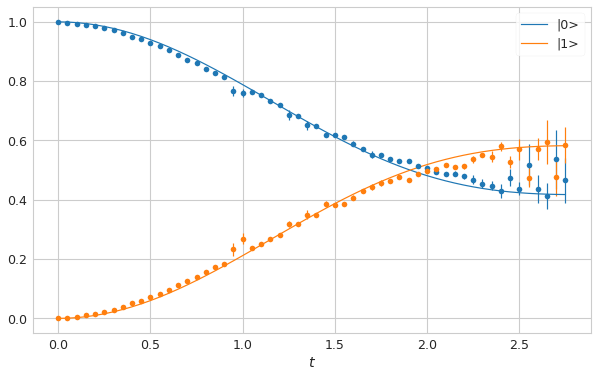

In [8]:
import pyqcs
import openqcs.qcirc as qu
import openqcs.statistic as st

def get_data(a, b, dt, plotting=False):
    H = sp.H_(a,b)
    T = sp.T_(H,dt)
    
    data, err, n_t = it.iterative_evolution(T)
    
    if plotting:
        it.plot_param(data, err, n_t, dt)
    
    return data, n_t

def QuantumEvolution(data, n_sample, iSt=pyqcs.State.new_zero_state(1), n_measure=1000, log=False,
                     filename=""):
    
    if log==True and filename=="":
        path = "./QuEvoData"
        if not os.path.exists(path):
            os.makedirs(path)
            
        filename=path+"/data.txt"
        
    
    probs = data[:,0]

    circs = np.ndarray((probs.shape[0],2), dtype=pyqcs.AnonymousCompoundGateCircuit)

    for i, d in enumerate(data):
        c1 = qu.su2_to_circuit(0, d[1:4])
        c2 = qu.su2_to_circuit(0, d[4:])
        circs[i,:] = [c1, c2]
        
        
    output = np.zeros((n_sample, 2), dtype=float)
    
    paths = []
    
    for i in range(n_sample):
        
        evolute_gates = np.ndarray(probs.shape[0], dtype=pyqcs.AnonymousCompoundGateCircuit)
        path=""
        for k, p in enumerate(probs):
            
            q = np.random.rand()
            if q < p:
                evolute_gates[k] = circs[k,0]
                path+="0"
            else:
                evolute_gates[k] = circs[k,1]
                path+="1"
        
        U_gate = pyqcs.list_to_circuit(evolute_gates)
        
        psi = U_gate*iSt
        
        res = pyqcs.sample(psi, 1, n_measure)
        paths.append(path)
        
        for key, val in res.items():
            output[i,key] = float(val)/n_measure
    
    paths = np.array(paths)
    
    if log:   
        file = open(filename, "w")
    
        for o in output:
            file.write("{}\t{}\n".format(o[0], o[1]))
            
        file.close()
    
    means = np.zeros(10, dtype=np.double)
    for i in range(10):
        tmp = np.random.choice(output[:,0], size=data.shape[0], replace=True)
        means[i] = np.mean(tmp)
    #mean0 = np.mean(output[:,0])
    #mean1 = np.mean(output[:,1])
    
    #err0 = np.std(output[:,0])
    #err1 = np.std(output[:,1])
    mean0, err0 = st.bootstrap(output[:,0])
    mean1, err1 = st.bootstrap(output[:,1])
   
    
    return mean0, err0, mean1, err1

def ClassicalEvolution(idx, T, rho0):
    
    rho = o.rho_sys_(T**idx, rho0)
    
    return rho[0,0], rho[1,1]
        
    

def main(saving=False, plotting=True):
    a = 0.5
    b = 0.5
    dt = 0.05
    
    n_sample = 20
    
    data, n_t = get_data(a,b,dt)
    
    t_data = np.arange(n_t) * dt
    qc_prob = np.zeros((n_t, 2,2), dtype=np.double)
    cl_prob = np.zeros((n_t, 2), dtype=np.double)
    
    H = sp.H_(a,b)
    T = sp.T_(H,dt)
    
    
    path = "./QuEvoData"
    if not os.path.exists(path):
        os.makedirs(path)

    
    
    iSt = pyqcs.State.new_zero_state(1)
    rho0 = np.matrix([[1,0],[0,0]])
    for i in range(n_t):
        print("#", end="", flush=True)
        m0, e0, m1, e1 = QuantumEvolution(data[:i+1], n_sample, iSt=iSt, log=True, 
                                          filename=path+"/t_{}.txt".format(i*dt))
        qc_prob[i,:,:] = [[m0, e0], [m1, e1]]
        
        r0, r1 = ClassicalEvolution(i, T, rho0)
        cl_prob[i,:] = [r0, r1]
        
    if plotting:
        
        colors = ["tab:blue", "tab:orange"]
        
        plt.figure(figsize=(10,6))
        
        
        for i in range(2):
            plt.plot(t_data, cl_prob[:,i], color=colors[i], label="|%d>"%i)
            plt.errorbar(t_data, qc_prob[:,i,0], yerr=qc_prob[:,i,1], 
                        color=colors[i], fmt="o")
            
        plt.legend()
        plt.xlabel("$t$")
            
        plt.show()
        
main()
        
        
    


In [ ]:
import time


def main():
    a = 0.5
    b = 0.5
    dt = 0.05

    n_samples = np.logspace(2, 3, 5, dtype=int)


    data, n_t = get_data(a,b,dt)


    H = sp.H_(a,b)
    T = sp.T_(H,dt)

    iSt = pyqcs.State.new_zero_state(1)
    rho0 = np.matrix([[1,0],[0,0]])

    times = np.zeros(n_samples.shape[0], dtype=np.double)
    probs = np.zeros((n_samples.shape[0], 2, 2), dtype=np.double)

    for i, n in enumerate(n_samples):
        print("n_sample = {}".format(n), flush=True)
        t_begin = time.time()
        m0, e0, m1, e1, paths = QuantumEvolution(data, n, iSt=iSt, log=True)
        probs[i,:,:] = [[m0, e0], [m1, e1]]
        t_end = time.time()
        times[i] = t_end - t_begin
        print("exicution time: ", t_end - t_begin)




    r0, r1 = ClassicalEvolution(i, T, rho0)


[0.630754   0.65566893 0.63350285 0.6371968  0.6403483 ]


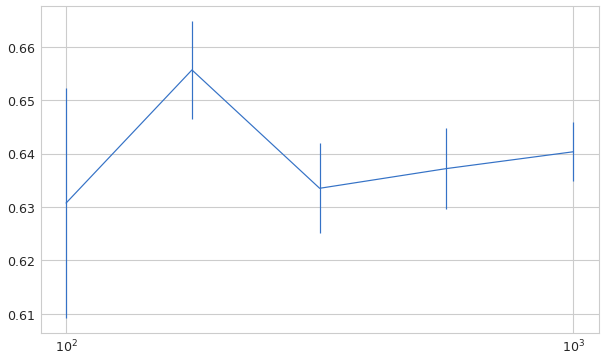

In [28]:
print(probs[:,0,0])

plt.figure(figsize=(10, 6))
plt.errorbar(n_samples, probs[:,0,0], yerr=probs[:,0,1])
plt.xscale("log")
plt.show()

### Result for $dt = 0.01$

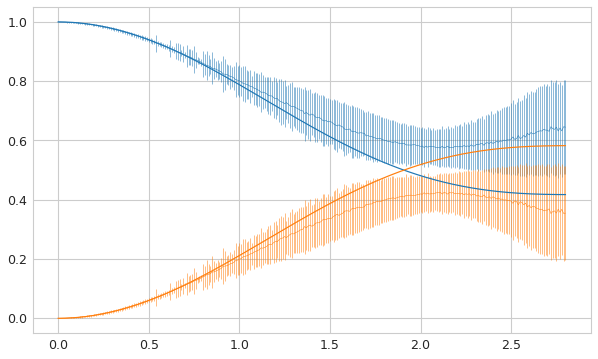

In [10]:
data = np.loadtxt("result_dt_0.01.txt")
cls = ["tab:blue", "tab:orange"]
plt.figure(figsize=(10, 6))
for i in range(2):
    plt.errorbar(data[:,0], data[:,2*i + 1], yerr=data[:,2*i + 2], label="|{}>".format(i), linewidth=.5,
                color=cls[i])
    plt.plot(data[:,0], data[:,5+i], color=cls[i])
plt.show()